### ECG Signals - SPEK

In this notebook we explore spectrograms as input representation for our deep learning model.

In [2]:
import torch
import torchaudio 
import wfdb
import sys
import wfdb
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing
import matplotlib.pyplot as plt
import librosa.display

print('Virtual Environment:')
print(sys.prefix)

Virtual Environment:
/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv


#### Updated Spectrogram Methods

Square tensors (spectrograms) are obtained by taking the right values for samples_to, n_fft and hop_length.

A bigger problem is the reconstruction part. We lose phase information, which means we will have to work with a lossy reconstruction. PytorchAudio has a Griffin Lim implementation we use for now. The probably best approach would be to use gradient ascent. Additional recources.

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 



Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [4]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

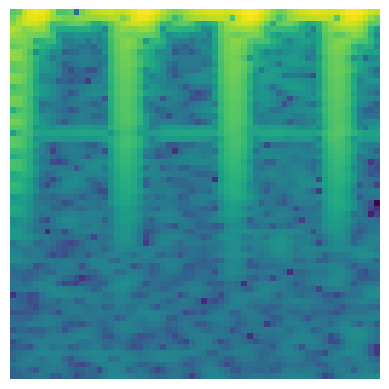

Griffin Time... torch.Size([1, 64, 64])


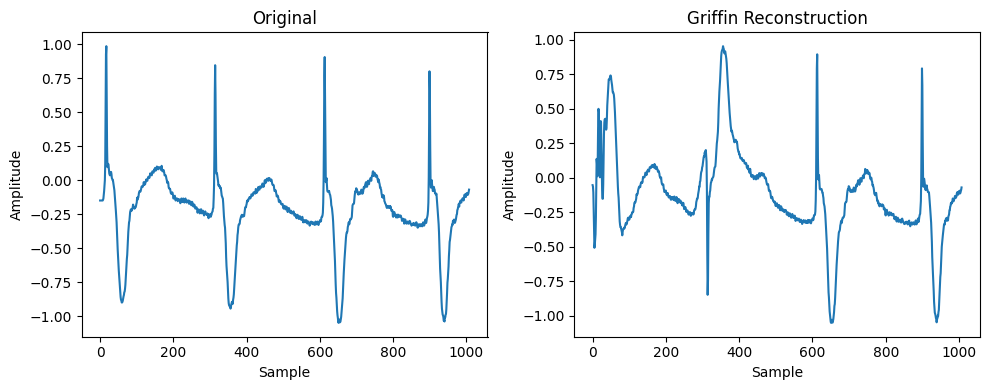

Duration 2.8


In [42]:
def visualize_tensor(tensor):
    """
    Visualize a tensor as an image.
    
    Parameters:
    tensor (torch.Tensor): The input tensor with shape [3, 540, 540].
    """
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()


def ecg_to_spectrogram_log(ecg_signal, n_fft=32, hop_length=4):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)

    # Take the log
    spec = spectrogram[0]
    spec_log = torch.log10(spec)

    return spec_log

def spectrogram_log_to_ecg(spec_log, n_fft=32, hop_length=None,n_iter=400):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Undo log operation
    spec = torch.pow(10, spec_log)

    # Debugging purpose
    print('Griffin Time...', spec.shape)

    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft,  n_iter=400, hop_length=hop_length)(spec)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

# Visualize Spek
def plot_spec(spec, title):
    """
    Plot spectrogram.

    Args:
    - spec (torch.Tensor): Spectrogram tensor.
    - title (str): Title of the plot.
    """
    plt.title(title)
    plt.imshow(librosa.amplitude_to_db(spec.numpy()), origin="lower", aspect="auto")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

######### Parameters ##########
samples_to = (62*16) + 16
n_fft = 126
hop_length = 16

# Load Data
path_102 = "data/ardb/104"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = -reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)


Duration in seconds... 5.644444444444445


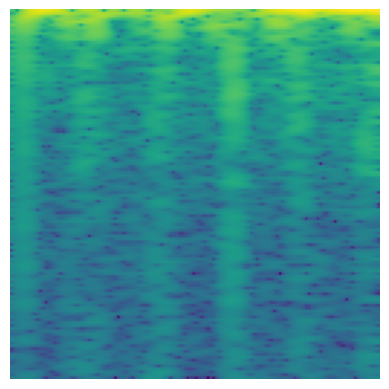

Griffin Time... torch.Size([1, 128, 128])


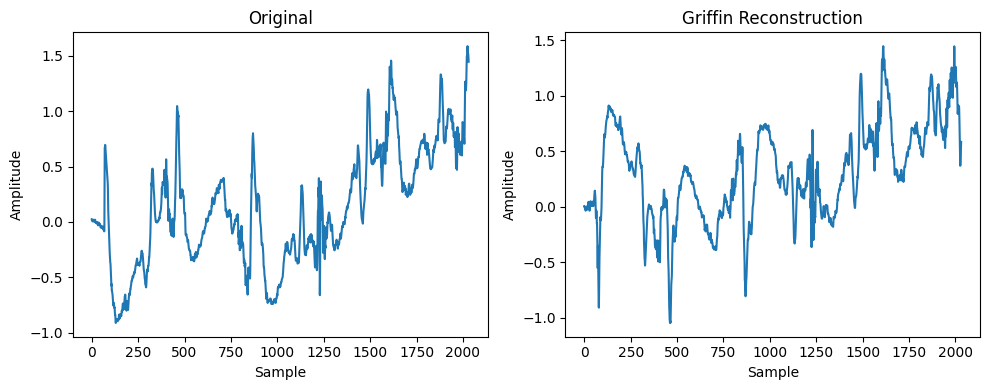

Number of samples: 2032
Duration in seconds: 5.644444444444445


In [50]:
######### Parameters ##########
samples_to = ((62*8*4) + 16) + 32
n_fft = 63*4 + 2
hop_length = 16

print('Duration in seconds...', samples_to/360)

# Load Data
path_102 = "data/nstdb/em"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)